In [1]:
%load_ext autoreload
%autoreload 2

import importlib.util
from pathlib import Path
import os

(PARAMETERS CELL) This cell runs with passed variables from feature_extractor.py otherwise it runs with it's own variables 

In [2]:
participant_id = "P1"
VidFile = Path("../../data/raw/videos").resolve()
AudFile = Path("../../data/raw/audio").resolve()
OutFile=Path("../../data/processed/interview_features.csv").resolve()
analyzer_paths = Path("../../src/utils").resolve()

In [3]:

print(analyzer_paths)
spec_facial= importlib.util.spec_from_file_location("face_analyzer", os.path.join(analyzer_paths,"face_analyzer.py"))
face_analyzer = importlib.util.module_from_spec(spec_facial)
spec_facial.loader.exec_module(face_analyzer)

C:\hireverse\src\utils

Project root: C:\hireverse


In [4]:

spec_lexical=importlib.util.spec_from_file_location("lexical_analyzer", os.path.join(analyzer_paths, "lexical_analyser.py"))
lexical_analyser = importlib.util.module_from_spec(spec_lexical)
spec_lexical.loader.exec_module(lexical_analyser)
# Use it like a module


In [5]:
face_analyzer = face_analyzer.FaceAnalyzer()
frames = face_analyzer.get_video_frames_for_participant(
    participant_id, VidFile, num_selected_frames=5)

# Lexical Features

In [6]:

Audio_File =Path(AudFile / f"Trimmed_{participant_id}.wav").resolve()
# Create an instance of the lexicalanalyser class
Lexicalanalyser = lexical_analyser.lexicalanalyser(str(Audio_File))
# Extract all features
lexical_features = Lexicalanalyser.extract_all_features()

# Print the extracted features
print(lexical_features)

LexicalFeatures(Total_words=514, Unique_words=282, Filler_words=18, Total_words_rate=3.1898916429803768, Unique_words_rate=1.750096193230479, Filler_words_rate=0.1117082676530093, Individual=35, We=9, They=1, Non_Fluences=18, PosEmotion=5, NegEmotion=0, Anxiety=1, Anger=0, Sadness=0, Cognitive=1, Inhibition=0, Preceptual=0, Relativity=0, Work=3, Swear=0, Articles=33, Negations=0, Quantifiers=1)


# Facial Features

### Face Mesh

In [7]:
for frame in frames:
    detected_faces_landmarks = face_analyzer.process_image_results(frame.image)
    frame.facial_landmarks_obj= face_analyzer.get_largest_face_landmarks_obj(frame.image, detected_faces_landmarks)
    if frame.facial_landmarks_obj:
        frame.facial_landmarks = frame.facial_landmarks_obj.landmark

### Face

In [8]:

for frame in frames:
    if frame.facial_landmarks:
        frame.face = face_analyzer.get_face_coordinates(frame.facial_landmarks, frame.image)

### Smile

In [9]:
import numpy as np


SMOOTH_WINDOW = 5
happiness_buffer = []
def smooth_happiness(happiness_prob):
    if happiness_prob is None:
        return 0 # TODO: change?
    happiness_buffer.append(happiness_prob)
    if len(happiness_buffer) > SMOOTH_WINDOW:
        happiness_buffer.pop(0)
    return np.mean(happiness_buffer)


for i, frame in enumerate(frames):
    face_roi = face_analyzer.get_face_roi_image(frame.image, frame.face, expand_ratio=1.1)
    frame.smile = smooth_happiness(face_analyzer.get_smile_from_frame(face_roi))

### Selected Facial Features

In [10]:
for frame in frames:
    frame.two_landmarks_connectors = face_analyzer.get_selected_facial_landmarks(frame.facial_landmarks)

### Head Pose

In [11]:

texts = []
for frame in frames:
    result = face_analyzer.get_face_angles(frame.image, frame.facial_landmarks)
    frame.face_angles = result

# Prosodic Extraction

In [12]:
spec_prosody = importlib.util.spec_from_file_location("prosody_analyzer", os.path.join(analyzer_paths, "prosody_analyzer.py"))
prosody_analyzer_module = importlib.util.module_from_spec(spec_prosody)
spec_prosody.loader.exec_module(prosody_analyzer_module)

ProsodicFeatures = prosody_analyzer_module.ProsodicFeatures
ProsodyAnalyzer = prosody_analyzer_module.ProsodyAnalyzer


In [13]:
from models.model_features import ProsodicFeatures
from src.utils.prosody_analyzer import ProsodyAnalyzer
 

prosody_analyzer = ProsodyAnalyzer(participant_id)
prosodic_features: ProsodicFeatures = prosody_analyzer.extract_all_features()
print(prosodic_features)

ProsodicFeatures(f0_mean=138.83111681385145, f0_min=75.34559605985413, f0_max=599.146950818701, f0_range=523.8013547588469, f0_sd=67.0853011294552, intensity_mean=-17.989479064941406, intensity_min=-36.43029022216797, intensity_max=0.0, intensity_range=36.43029022216797, intensity_sd=7.597977638244629, f1_mean=626.2173706460607, f1_sd=255.61800471795644, f2_mean=1801.0016796933098, f2_sd=369.1933597973028, f3_mean=2718.601820697813, f3_sd=363.6766279398201, f2_f1_mean=3.209346917850346, f3_f1_mean=4.813353523730428, f2_f1_sd=1.1984938994192222, f3_f1_sd=1.511679439759952, jitter=0.02250039669976775, shimmer=0.17853661247110367, percent_unvoiced=14.22418608114985, percent_breaks=1.6075754239154016, max_pause_duration=2.429999999999999, avg_pause_duration=0.31397260273972616, duration=161.134)


# Features Storage

### Facial Features Aggregation

In [14]:
from src.utils.feature_storage import FeatureStorage

feature_storage = FeatureStorage(OutFile)
facial_features = feature_storage.aggregate_facial_features(frames)

In [17]:

feature_storage.save_to_csv(participant_id, prosodic_features, facial_features, lexical_features)

Feature attributes: {'f0_mean': 138.83111681385145, 'f0_min': 75.34559605985413, 'f0_max': 599.146950818701, 'f0_range': 523.8013547588469, 'f0_sd': 67.0853011294552, 'intensity_mean': -17.98948, 'intensity_min': -36.43029, 'intensity_max': 0.0, 'intensity_range': 36.43029, 'intensity_sd': 7.5979776, 'f1_mean': 626.2173706460607, 'f1_sd': 255.61800471795644, 'f2_mean': 1801.0016796933098, 'f2_sd': 369.1933597973028, 'f3_mean': 2718.601820697813, 'f3_sd': 363.6766279398201, 'f2_f1_mean': 3.209346917850346, 'f3_f1_mean': 4.813353523730428, 'f2_f1_sd': 1.1984938994192222, 'f3_f1_sd': 1.511679439759952, 'jitter': 0.02250039669976775, 'shimmer': 0.17853661247110367, 'percent_unvoiced': 14.22418608114985, 'percent_breaks': 1.6075754239154016, 'max_pause_duration': 2.429999999999999, 'avg_pause_duration': 0.31397260273972616, 'duration': 161.134}
Feature attributes: {'average_outer_brow_height_mean': 0.015619049796362885, 'average_inner_brow_height_mean': 0.015452793669477877, 'eye_open_mean'

# Display Frames

Project root: C:\hireverse


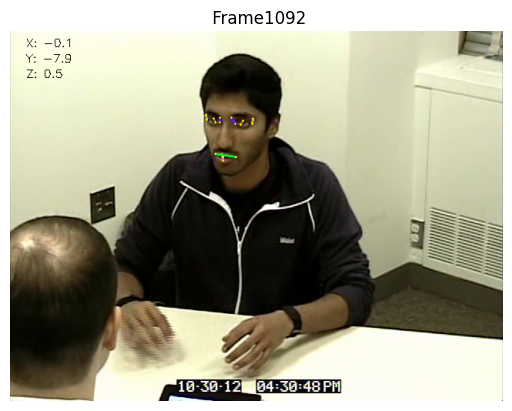

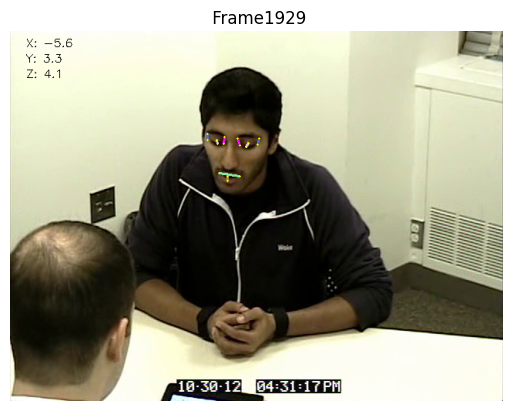

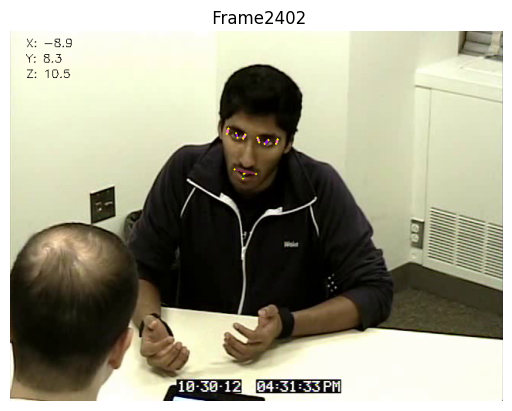

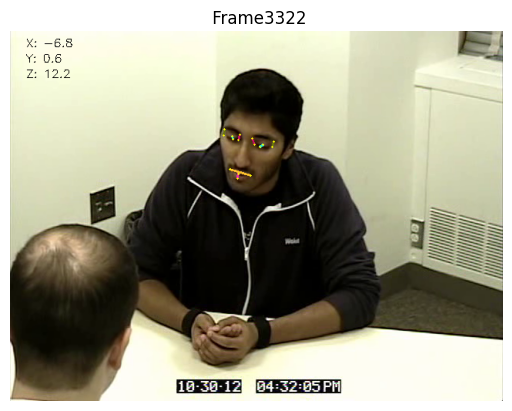

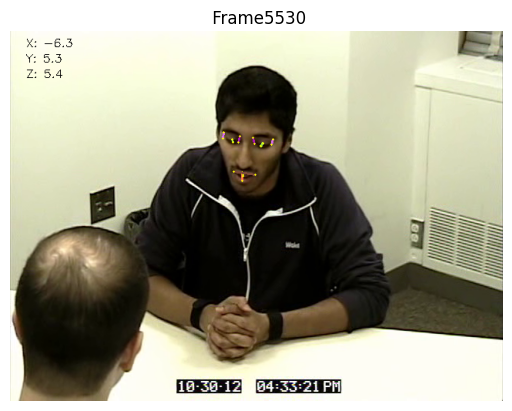

In [16]:
for frame in frames:
    frame.reset_drawable_image()
    # frame.draw_face_border()
    
    frame.draw_selected_facial_landmarks(draw_lines=True)
    
    frame.put_face_angles()
    # frame.draw_facial_landmarks()
    frame.display()